# IBM SETI Tutorial

## Get data from Object Store and calculate features

In [1]:
#!pip install --user --upgrade ibmseti
#!pip install --user --upgrade ibmos2spark
import ibmseti
import ibmos2spark as oss
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
credentials_1 = {
  'auth_uri':'',
  'global_account_auth_uri':'',
  'username':'xxx',
  'password':"xxx",
  'auth_url':'https://identity.open.softlayer.com',
  'project':'xxx',
  'project_id':'xxx',
  'region':'dallas',
  'user_id':'xx',
  'domain_id':'xx',
  'domain_name':'xx',
  'container':'seti_raw_data',
  'tenant_id':'xx'
}

credentials_1['name'] = 'my_seti_data'

In [3]:
bmos = oss.bluemix2d(sc, credentials_1)
rdd = sc.pickleFile(bmos.url('seti_raw_data', 'kepler1229b.sigdb.archive-compamps.rdd.dict.pickle'))

## Extract the Spectrograms from each file

In [4]:
def extract_spectrogram_and_bins(row):

    aca = ibmseti.compamp.Compamp(row['raw_data'])
    
    spect = ibmseti.dsp.compamp_to_spectrogram(aca)  
    
    #calculates the frequency (fb) and time (tb) bins
    fb = ibmseti.dsp.frequency_bins(aca.header())
    tb = ibmseti.dsp.time_bins(aca.header())

    return (tb, fb, aca.header(), spect)

In [5]:
rdd = rdd.map(extract_spectrogram_and_bins)

## Example Feature: "standard deviation" 

The standard deviation of a set of values is used to measure the "width" of the distribution of those values about its central value. In our case, it's used as a proxy to estimate if a signal exists in the spectrogram.

We calculate a mean standard deviation for each axis. 

Consider a spectrogram of N frequency bins (typically 6144) and M time bins (typically 129). Stepping through the calculation, we start with the variance "along the time axis".

`var_t = ibmseti.features.moment( spectrogram, axis=0, moment=2)` 

The array `var_t` is of length N, where each element is the variance of the M values for each particular frequency bins. 

Then `np.sqrt(var_t)` takes the square root and leaves an array of size N. We've calculated the standard deviation, the "width", of the M values for each frequency bin. Finally, `std_time` is the mean of those N values. 

We do the same for the other axis, calculating the mean standard deviation "along the frequency axis" for each of the time bins, which we call `std_freq`.  


### Typical Narrow Band Signal

For a typical narrow-band signal with a relatively small amount of drift, the `std_freq` will be relatively large. This is because at each of the M time intervals, the set of the values across all frequencies will contain a large number of small noise values and a large number of large signal values -- thus, a wide distribution of numbers. Along the time-axis, the `std_time` will be relatively small because for most of the frequency bins, there will be just noise in a small range of values just above zero. There will, of course, be a handful of frequency bins with large widths as the signal passes through that frequency. But the vast majority will be noise, resulting in a small `std_time`.

### Wideband Pulse

Conversely, a signal that is seen across a wide range of frequencies, but only for a short duration, will have a small `std_freq` and a large `std_time`. 

In [6]:
import math

def extract_mean_std(row):
    std_time = np.mean(np.sqrt(ibmseti.features.moment( row[3], axis=0, moment=2)))
    std_freq = np.mean(np.sqrt(ibmseti.features.moment( row[3], axis=1, moment=2)))
    return (std_time, std_freq)

In [7]:
rdd_features = rdd.map(extract_mean_std)

In [8]:
%time npfeat = np.array(rdd_features.collect())

CPU times: user 5.9 ms, sys: 6.85 ms, total: 12.7 ms
Wall time: 22.2 s


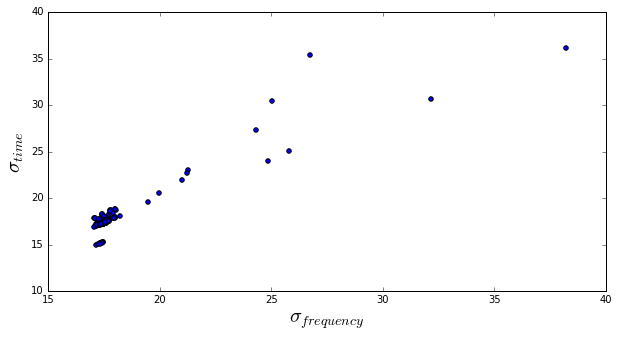

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter( npfeat[:, 1], npfeat[:, 0])
plt.xlabel(r'$\sigma_{frequency}$', fontsize=20)
plt.ylabel(r'$\sigma_{time}$', fontsize=20)
plt.show()


### Features In Context

Some work has been done already to extract the 'mean_std' features for all archive-compamp files.

http://imgur.com/siffvT8

From that link, you'll see these data fall right in the middle of that full archive-compamp set. The idea is to come up with features that allow for classification of signals. This is very much unexplored data!


## More features to be considered:

* std of spectrogram projected on time and freq axis
* third and fourth moments (std is sqrt(2nd moment))
* Log(pixel) histogram fits
* Entropy
* Total Variation
* Maximum Variation
* Mean first-difference
* 2nd, 3rd and 4th moments of first-difference
* Excess Kurtosis